In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import csv
from IPython.display import Image
from IPython.display import display

In [2]:
df_postn = pd.read_csv('final_twitter_preprocessing_utf16.csv', encoding = 'UTF-16LE', sep=',')
display(df_postn.head(3))
print(len(df_postn))

,Unnamed: 0,no,key,created_time,message,lang,re_message
0,0,0,enbrel,2/23/2017 10:28,@NASSexercise I haven't been on #antiTNF since...,english,nassexercise haven't antitnf since december rh...
1,1,1,humira,2/23/2017 10:28,@NASSexercise I haven't been on #antiTNF since...,english,nassexercise haven't antitnf since december rh...
2,2,2,humira,2/23/2017 11:12,@mumwithas December isn't that long ago and Hu...,english,mumwithas december isn't humira stay system co...


9048


In [3]:
# Importing Gensim
import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
corpus=list(df_postn['re_message'])
def tokenize(doc):
    tokens = ' '.join(re.findall(r"[\w']+", str(doc))).lower().split()
    x = [''.join(c for c in s if c not in string.punctuation) for s in tokens]
    x=' '.join(x)
    #print(x)
    stop_free = " ".join([i for i in x.lower().split() if i not in stop])
    #print(doc.lower().split())
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word,pos='n') for word in punc_free.split())
    normalized = " ".join(lemma.lemmatize(word,pos='v') for word in normalized.split())
    word = " ".join(word for word in normalized.split() if len(word)>3)
    #print(word.split())
    postag=nltk.pos_tag(word.split())
    #print(postag)
    #irlist=[',','.',':','#',';','CD','WRB','RB','PRP','...',')','(','-','``','@']
    poslist=['NN','NNP','NNS','RB','RBR','RBS','JJ','JJR','JJS']
    wordlist=['co', 'https', 'http','rt','www','ve','dont',"i'm","it's"]
    adjandn = [word for word,pos in postag if pos in poslist and word not in wordlist and len(word)>3]
    #normalized = adjandn.split()
    return ' '.join(adjandn)
doc_clean = [tokenize(doc).split() for doc in corpus]
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)
#clean("Why you are so late'''''?for knowing nothing cute")
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [4]:
import gensim
from gensim import corpora
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
#ldamodel = Lda(doc_term_matrix, num_topics=20, id2word = dictionary, passes=20)
ldamodel = Lda(doc_term_matrix, num_topics=30, id2word = dictionary, update_every=10, chunksize=10000, passes=5)
#lda.printTopics(k)

In [5]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.display(vis_data)
#pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

In [6]:
#doc_clean_2017 = [tokenize(doc).split() for doc in corpus_2017]
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
#dictionary_2017 = corpora.Dictionary(doc_clean_2017)
#clean("Why you are so late'''''?for knowing nothing cute")
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
#doc_term_matrix_2017 = [dictionary_2017.doc2bow(doc) for doc in doc_clean_2017]
def getTopicForQuery(question):
    temp = tokenize(question).split()
    #print(temp)
    ques_vec = []
    ques_vec = dictionary.doc2bow(temp)
    topic_vec = []
    topic_vec = ldamodel[ques_vec]
    word_count_array = np.empty((len(topic_vec), 2), dtype = np.object)
    for i in range(len(topic_vec)):
        word_count_array[i, 0] = topic_vec[i][0]
        word_count_array[i, 1] = topic_vec[i][1]

    idx = np.argsort(word_count_array[:, 1])
    idx = idx[::-1]
    word_count_array = word_count_array[idx]
    final = []
    final = ldamodel.print_topic(word_count_array[0, 0], 100)
    #print(final)
    question_topic = final.split('*') ## as format is like "probability * topic"
    tokens = ' '.join(re.findall(r"[\w']+", str(final))).lower().split()
    x = [''.join(c for c in s if c not in string.punctuation) for s in tokens]
    #print(x)
    result = ' '.join([i for i in x if not i.isdigit()])
    #x=' '.join(x)
    print("Original Query: ",question)
    print("(Topic, Probability): ",ldamodel.get_document_topics(ques_vec))
    #resword=ldamodel_2017.print_topic(ldamodel_2017.get_document_topics(ques_vec)[0][0])
    #print("Relevant Words:\n ")
    #display(ldamodel_2017.print_topic(ldamodel_2017.get_document_topics(ques_vec)[0][0]))
    return result.split()[0:9]

In [7]:
topicwords={}
#ldamodel.show_topics(30,10)
#print(topicwords)
no=0
for prob in ldamodel.show_topics(30,10):
    #print(prob)
    #print(prob[1])
    tokens = ' '.join(re.findall(r"[\w']+", str(prob[1]))).lower().split()
    x = [''.join(c for c in s if c not in string.punctuation) for s in tokens]
    result = ' '.join([i for i in x if not i.isdigit()])
    topicwords[no]=result.split()
    no+=1
for i in range(30):
    print("Topic",i,": ",topicwords[i])
#def gettopicwords_2017()

Topic 0 :  ['arthritis', 'abbvie', 'rheumatoid', 'psoriasis', 'myers', 'bristol', 'amgen', 'company', 'disease', 'treatment']
Topic 1 :  ['addition', 'severe', 'moderate', 'psoriasis', 'data', 'fingernail', 'abbvies', 'network', 'international', 'bristol']
Topic 2 :  ['arthritis', 'rheumatoid', 'therapy', 'choice', 'prognosis', 'tool', 'treatment', 'test', 'oral', 'link']
Topic 3 :  ['humira', 'myers', 'bristol', 'oncology', 'immuno', 'psoriasis', 'network', 'international', 'abbvie', 'help']
Topic 4 :  ['ibrutinib', 'psoriasis', 'data', 'study', 'phase', 'patient', 'research', 'relapse', 'meet', 'american']
Topic 5 :  ['humira', 'biosimilar', 'investment', 'patent', 'adalimumab', 'plan', 'medicine', 'precision', 'enbrel', 'focus']
Topic 6 :  ['bristol', 'myers', 'arthritis', 'rheumatoid', 'vitamin', 'bristolmyerssquibb', 'disease', 'present', 'cancer', 'trial']
Topic 7 :  ['abbvie', 'humira', 'patient', 'court', 'spondylitis', 'patent', 'ankylose', 'share', 'janebrophyld', 'seananstee

In [8]:
question="I feel painful, psoriasis suffers a lot. Can someone help me"
getTopicForQuery(question)

Original Query:  I feel painful, psoriasis suffers a lot. Can someone help me
(Topic, Probability):  [(21, 0.22829999337258622), (29, 0.61614445107167404)]


['psoriasis',
 'spondylitis',
 'humira',
 'ankylose',
 'support',
 'patient',
 'disease',
 'shoot',
 'time']

In [9]:
print(question)

I feel painful, psoriasis suffers a lot. Can someone help me


In [12]:
from sklearn import datasets
from sklearn.metrics import *
iris = datasets.load_iris()
X = pd.DataFrame(iris.data)
y = pd.DataFrame(iris.target,columns = ['cluster'])
s = silhouette_score(doc_term_matrix, iris.target, sample_size=1000)

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.704978749608


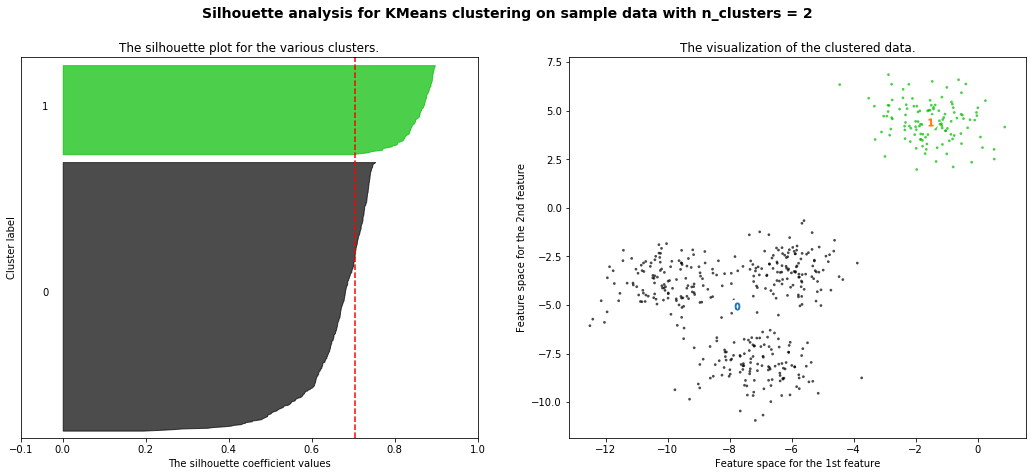

For n_clusters = 3 The average silhouette_score is : 0.588200401213


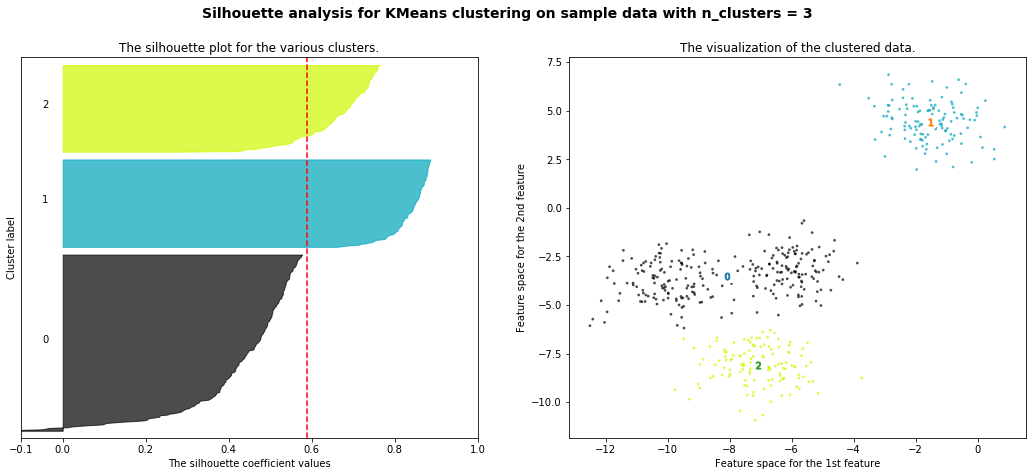

For n_clusters = 4 The average silhouette_score is : 0.650518663273


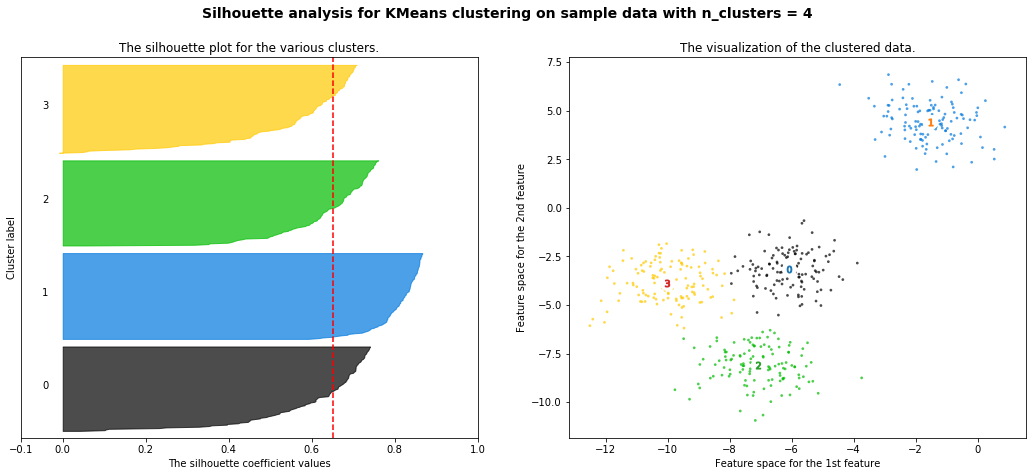

For n_clusters = 5 The average silhouette_score is : 0.563764690262


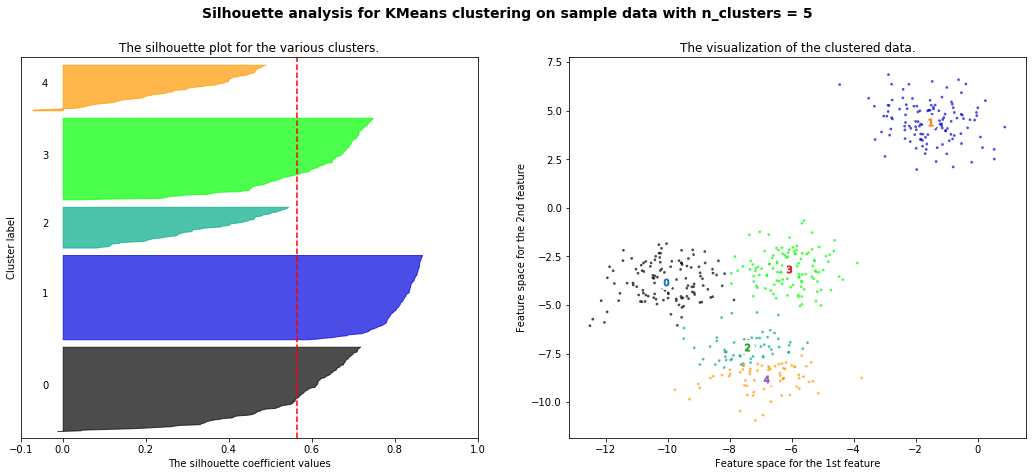

For n_clusters = 6 The average silhouette_score is : 0.450466629437


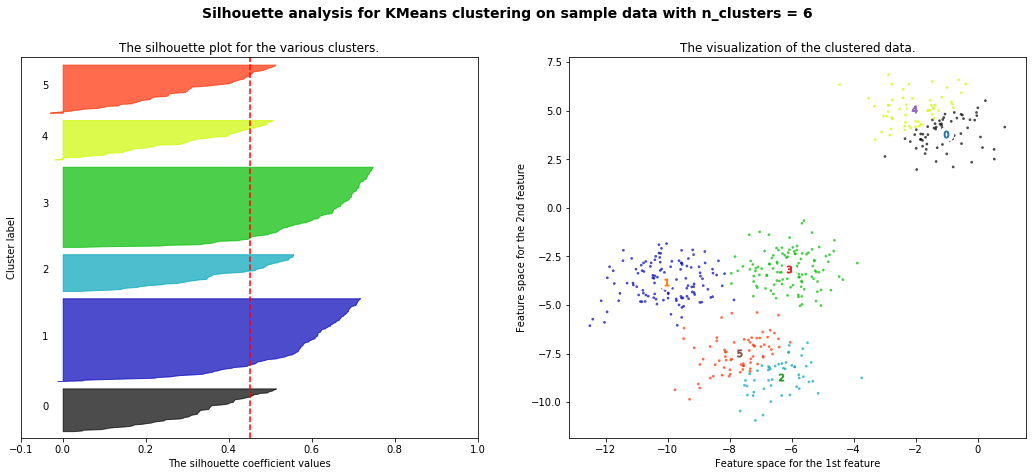

In [17]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

array([2, 2, 1, 0, 3, 0, 3, 3, 1, 3, 2, 2, 3, 0, 3, 2, 1, 2, 0, 3, 1, 1, 3,
       0, 3, 3, 0, 0, 1, 3, 2, 0, 3, 2, 3, 2, 1, 1, 2, 1, 3, 1, 0, 3, 3, 2,
       1, 3, 0, 0, 0, 1, 1, 3, 2, 1, 1, 1, 1, 3, 0, 0, 1, 3, 0, 3, 2, 3, 1,
       1, 2, 1, 3, 2, 3, 3, 2, 3, 3, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 2,
       1, 3, 0, 2, 2, 3, 2, 0, 0, 2, 0, 1, 0, 3, 3, 0, 0, 1, 3, 2, 0, 1, 0,
       1, 0, 3, 0, 3, 1, 2, 2, 1, 3, 1, 0, 2, 2, 3, 0, 1, 1, 1, 1, 2, 0, 3,
       0, 0, 3, 2, 3, 0, 0, 0, 3, 3, 2, 2, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 2, 2, 2, 3, 0, 2, 1, 3, 2, 0, 1, 1, 1, 1, 2, 3, 1, 0, 2,
       2, 1, 3, 2, 2, 3, 0, 0, 2, 2, 3, 0, 3, 2, 2, 0, 2, 1, 0, 3, 3, 2, 3,
       1, 2, 3, 1, 3, 1, 2, 3, 3, 3, 0, 1, 0, 3, 2, 1, 3, 1, 1, 1, 0, 3, 0,
       2, 1, 2, 1, 0, 0, 1, 2, 0, 2, 3, 1, 2, 2, 2, 2, 3, 1, 2, 1, 3, 0, 0,
       3, 3, 0, 1, 3, 1, 0, 3, 0, 1, 1, 0, 3, 2, 2, 1, 1, 1, 3, 0, 0, 3, 0,
       1, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 3, 1, 1, 1, 3, 3, 3, 2, 0, 2, 1, 2,
       3, 2,

In [20]:
doc_term_matrix

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1)],
 [(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1)],
 [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1)],
 [(9, 1), (14, 2), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1)],
 [(20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1)],
 [(9, 1), (30, 1), (31, 1), (32, 1)],
 [(8, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1)],
 [(9, 1), (37, 1)],
 [(20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (38, 1)],
 [(7, 1), (39, 1), (40, 1), (41, 1), (42, 1)],
 [(8, 1), (20, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)],
 [(8, 1),
  (20, 1),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 2),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1)],
 [(9, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
 

In [22]:
dictionary.doc2bow(doc_clean[0])

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]